# Imports and data path

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from natsort import index_natsorted

In [2]:
# define plotting parameters
fontsize = 14
plt.rcParams['axes.linewidth']=0.5
plt.rcParams['axes.labelsize']=fontsize
plt.rcParams['lines.linewidth']=0.5
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.major.width']=1
plt.rcParams['ytick.major.width']=1
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['savefig.bbox']='Tight'
plt.rcParams['savefig.dpi']=300

In [3]:
# Define output paths
output='../outputs/'
data ='../data/'

# Processing data after cutadapt and counting guides

**Different treatment conditions**

1) r0c0_t1: untreated, uninduced at timepoint 1

2) r0c0_t2: untreated, induced at timepoint 2

3) r0c100_t2: 100 µM P2-56-3 treatment, induced at timepoint 2

4) r7c0_t2: 0.7 µg/mL RIF treatment, induced at timepoint 2

5) r7c100_t2: 0.7 µg/mL RIF with 100 µM P2-6-3 treatment, induced at timepoint 2



**Steps for processing**

1) Read in counts file from previous data processing from sequencing

2) Remove sgRNAs that have total count <20 across replicates in t1 (first timepoint) condition

3) Replace all 0s with 1s in raw read counts

4) Normalize the data by the total number of sgRNAs per condition/replicate prior to the 0 adjustment

5) Read in expansion factors and perform calculation

6) Calculate fitness yielded by each sgRNA in each sample and replicate separately

fitness = ln[normdfreq@t2*(expansion/normdfreq@t1)]/ln[(1-normdfreq@t2)*expansion/(1-normdfreq@t1)]


## Read in counts file from previous data processing from sequencing

In [7]:
# Read in count files
count_files = glob.glob(data+'*.fastq.counts')

In [68]:
# Read in first counts to initilize the dataframe
count_df = pd.read_csv(count_files[0],delimiter='\t',header=None,index_col=0)
count_df.columns = ['_'.join(count_files[0].split('../data/')[1].split('.fastq.counts')[0].split('_')[1:])]

# Read in files for aggregation and merge into existing dataframe
for file in count_files[1:]:
    curr_df = pd.read_csv(file,delimiter='\t',header=None,index_col=0)
    curr_df.columns = ['_'.join(file.split('../data/')[1].split('.fastq.counts')[0].split('_')[1:])]
    count_df = count_df.merge(curr_df,left_index=True,right_index=True)
    
# Rename index column
count_df.index.name = 'Guide Sequence'

In [71]:
# Read in guide info
guide_info = pd.read_excel(data+'12,000 Guide Library Details.xlsx')

# Merge with count data
labeled_count_df = guide_info.merge(count_df,on=['Guide Sequence'])

In [75]:
# Save to dataframe
labeled_count_df.to_excel(data+'assigned_sgRNAs.xlsx',index=False)

## Check sgRNA count distributions and normalize data after raw reads replacement 0s with 1s

In [76]:
# Read in raw count data connected to labels
raw_df = pd.read_excel(data+'assigned_sgRNAs.xlsx')

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


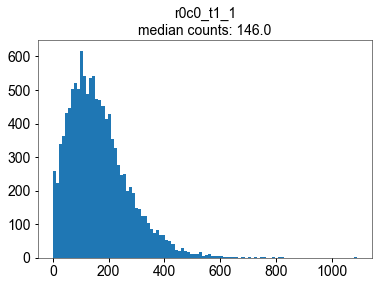

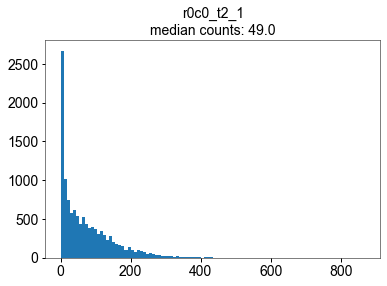

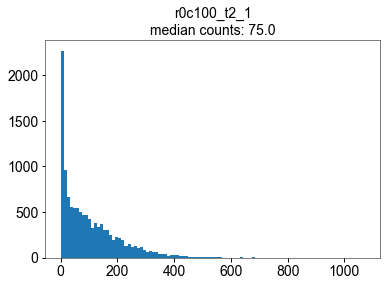

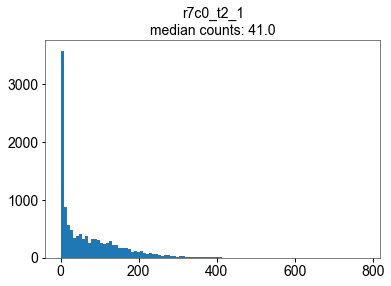

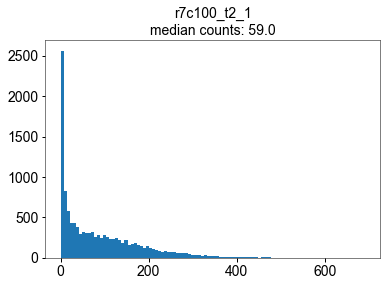

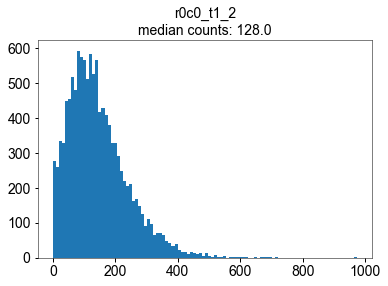

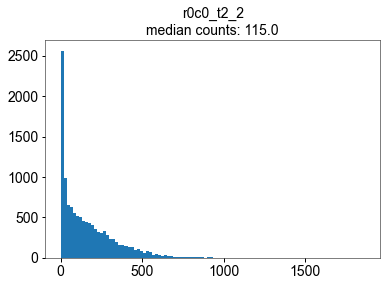

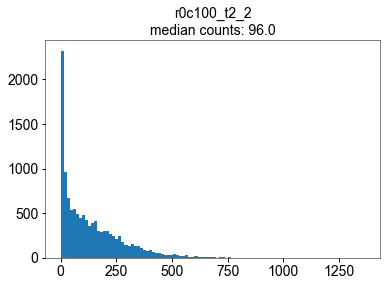

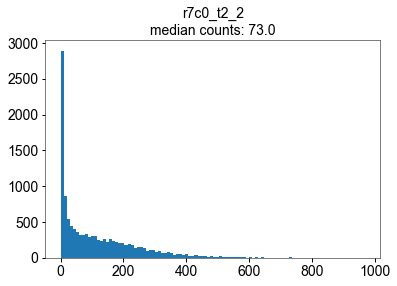

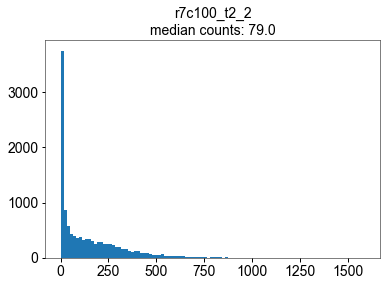

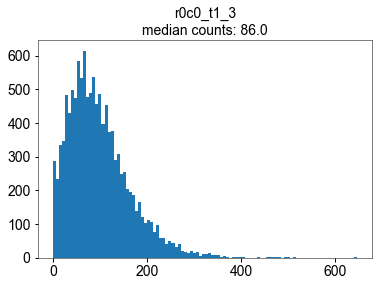

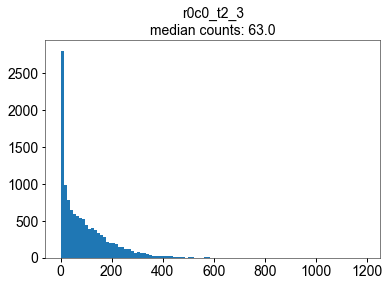

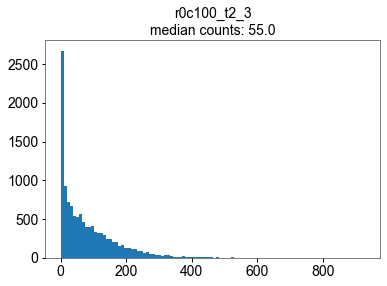

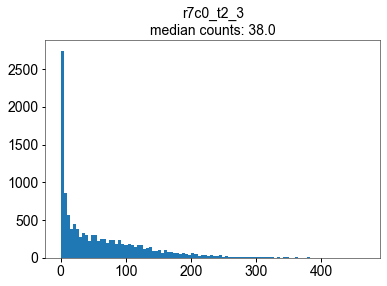

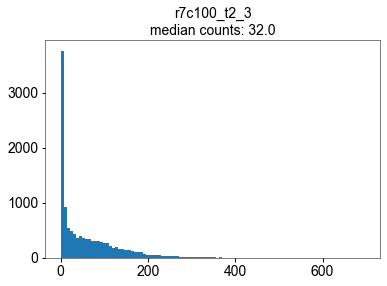

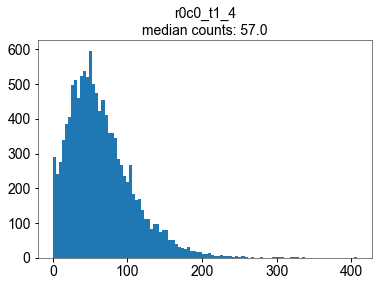

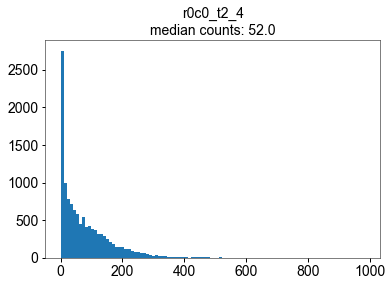

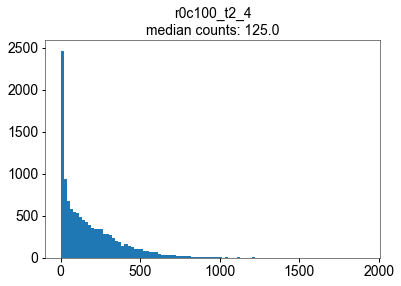

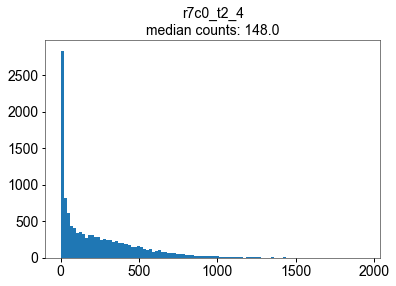

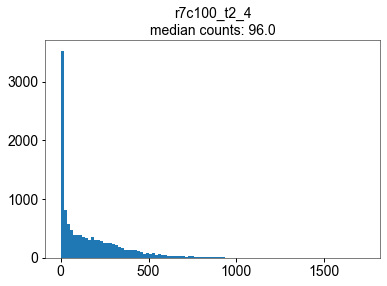

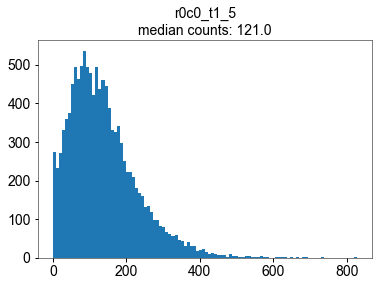

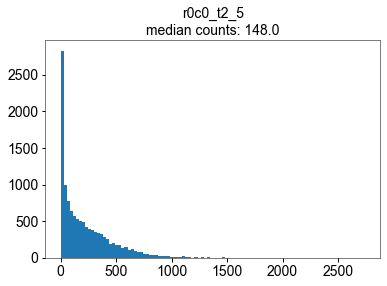

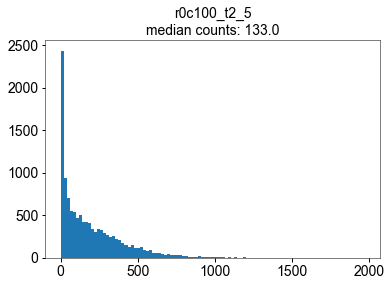

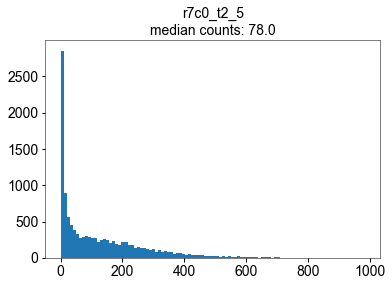

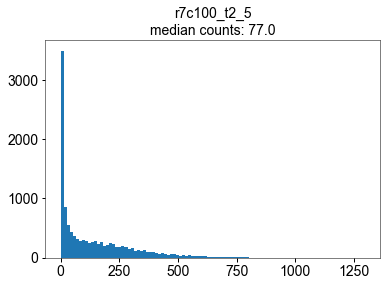

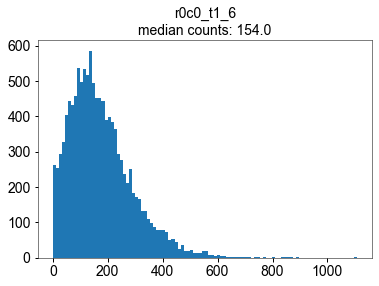

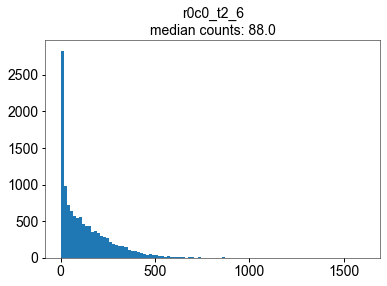

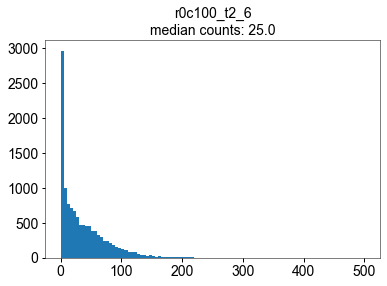

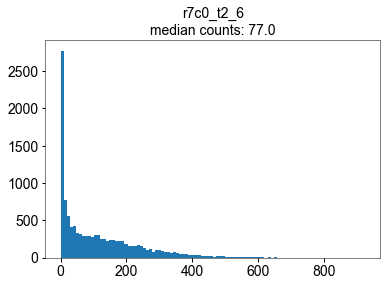

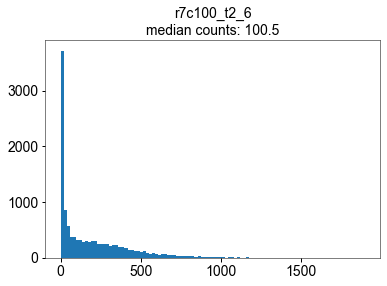

In [5]:
# Sum the total number of sgRNAs across replicates
raw_df['total_across_reps'] = raw_df[raw_df.columns[raw_df.columns.str.contains('r0c0_t1')]].sum(axis=1)

# Pull out data columns
data_df = raw_df.iloc[:,3:33]

# Plot the raw read count distributions
for i in range(data_df.shape[1]):
    fig, ax = plt.subplots()
    plt.hist(data_df.iloc[:,i],bins=100)
    plt.title(data_df.columns[i]+'\nmedian counts: '+ str(np.median(data_df.iloc[:,i])))

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


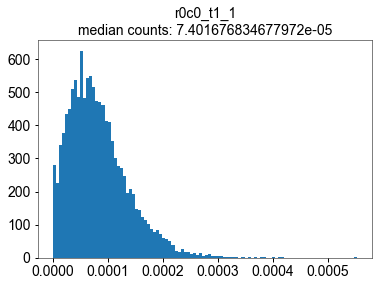

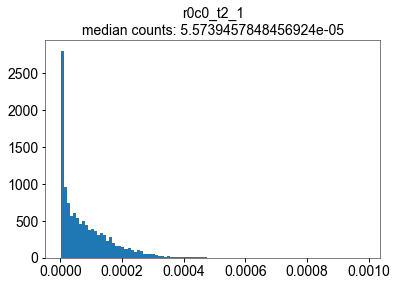

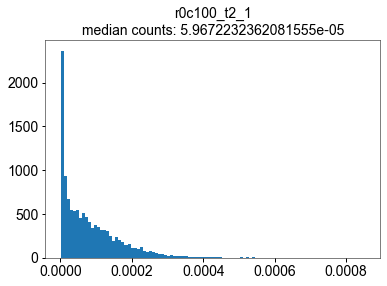

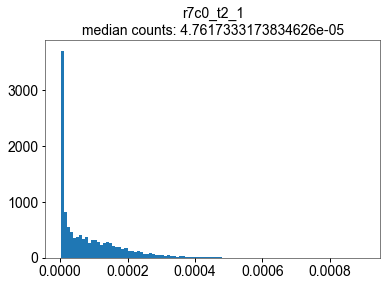

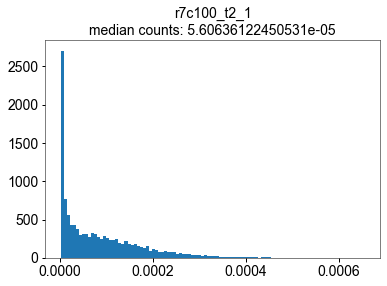

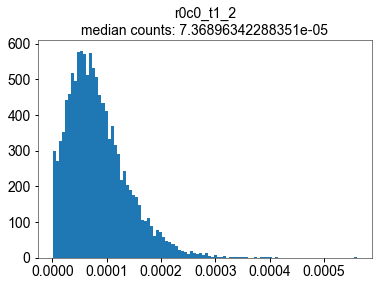

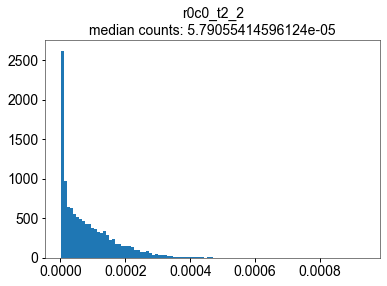

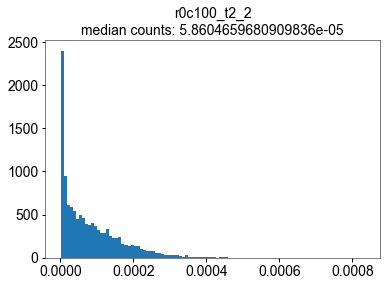

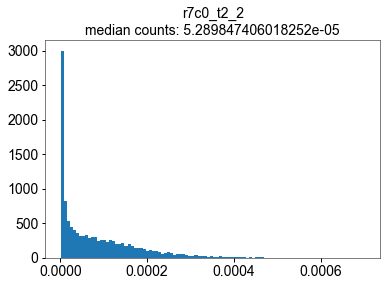

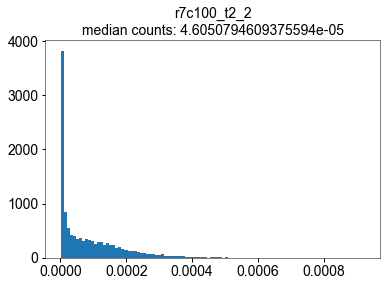

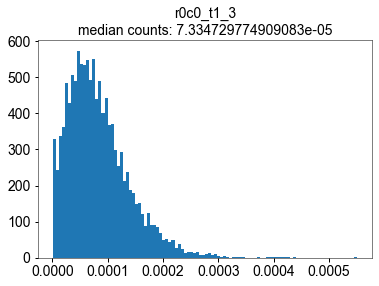

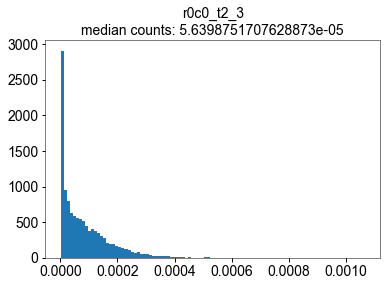

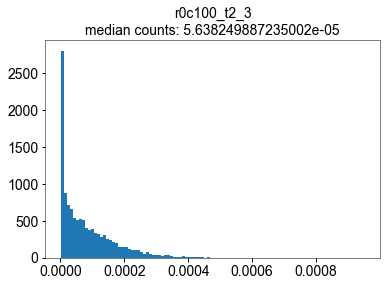

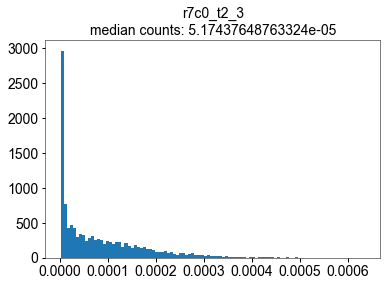

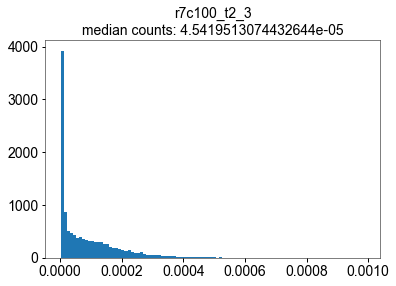

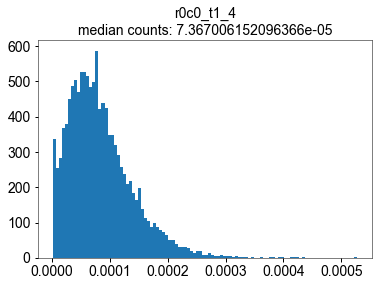

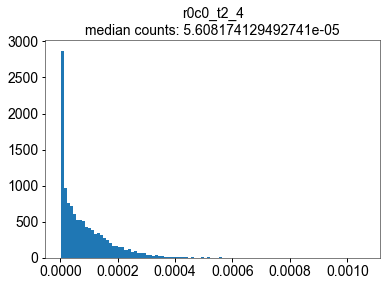

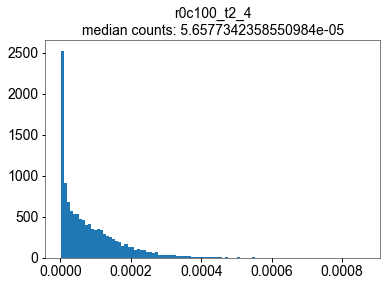

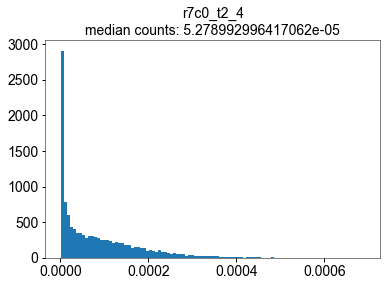

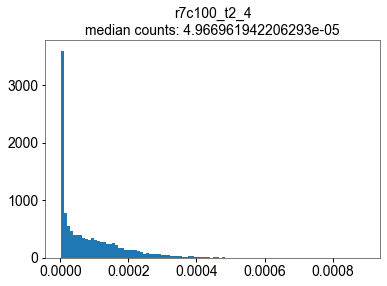

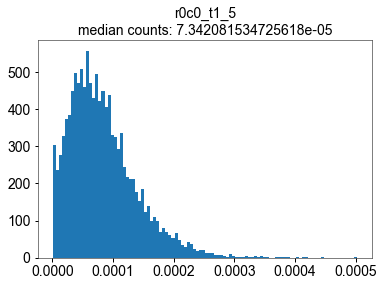

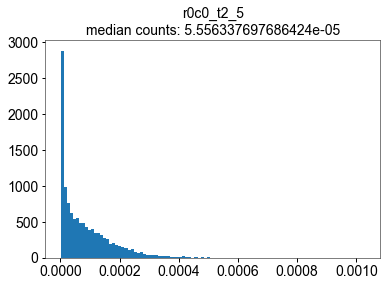

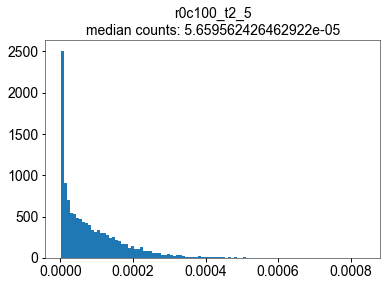

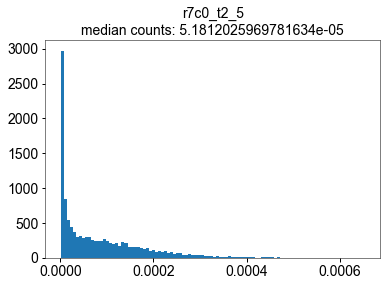

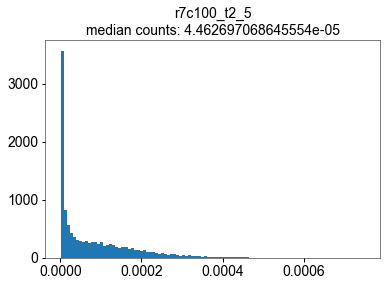

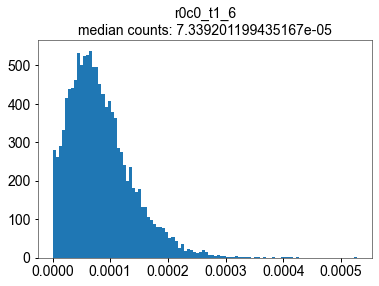

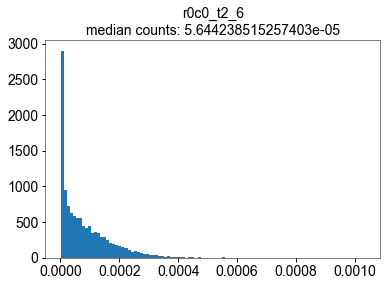

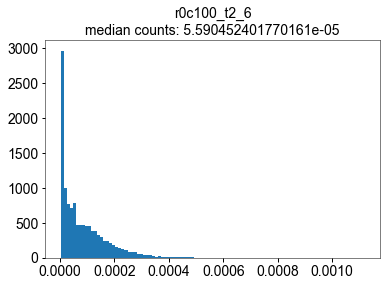

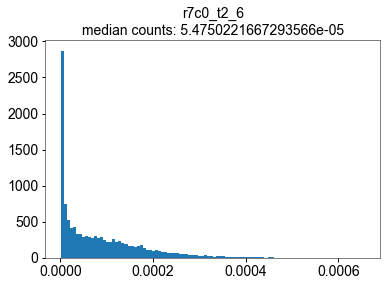

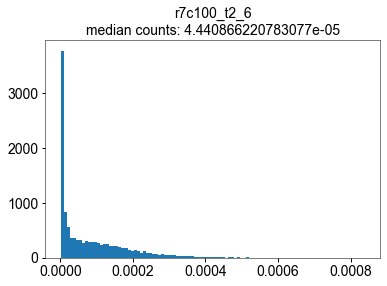

In [6]:
# Replace 0s with 1s
zfilled_data_df = data_df.replace(0,1)

# Divide to get normalized reads
norm_data_df = zfilled_data_df.divide(data_df.sum(axis=0).values,axis=1)

# Plot the normalized read count values to check
for i in range(norm_data_df.shape[1]):
    fig, ax = plt.subplots()
    plt.hist(norm_data_df.iloc[:,i],bins=100)
    plt.title(norm_data_df.columns[i]+'\nmedian counts: '+ str(np.median(norm_data_df.iloc[:,i])))

In [7]:
# Merge normalized read count data back into original dataframe
all_data_df = pd.merge(raw_df, norm_data_df, left_index=True, right_index=True,suffixes=('','_norm'))
all_data_df.to_csv(data+'all_zfilled_normalized_data.csv',index=False)

## Mark sgRNAs to exclude from downstream analyses

In [8]:
# Filter out any sgRNAs<20 counts across replicates
fil_data_df = all_data_df.query('total_across_reps>=20')
fil_data_df.to_csv(data+'filtered_normalized_data.csv',index=False)

## Calculate fitness scores

In [9]:
# Read in filtered data
fil_data_df = pd.read_csv(data+'filtered_normalized_data.csv')

In [10]:
# Read in expansion factor data
ef_data = pd.read_excel(data+'expansion_factors.xlsx',index_col=0)
ef_dict = dict(zip(ef_data.T.index+'_norm',ef_data.T.expansion_factor))

# Conditions to calculate values for
conditions = ef_data.columns+'_norm'

for cond in conditions[:]:
    # corresponding t1 column
    t1_name = 'r0c0_t1_'+cond.split('_norm')[0][-1]+'_norm'

    # Calculate fitness scores
    ### ln[normdfreq@t2*(expansion/normdfreq@t1)]/ln[(1-normdfreq@t2)*expansion/(1-normdfreq@t1)]
    fitness_scores = np.log(fil_data_df[cond]*(ef_dict[cond]/fil_data_df[t1_name]))/np.log((1-fil_data_df[cond])*(ef_dict[cond]/(1-fil_data_df[t1_name])))
    
    # Add to filtered df
    fil_data_df[cond+'_fitness'] = fitness_scores
    
# Save dataframe
fil_data_df.to_csv(data+'filtered_fitness_data.csv',index=False)

## Normalize fitness values to negative/neutral controls

In [11]:
# Read in list of actual negative controls
selected_neg_df = pd.read_excel(data+'Shuffles Selected for Normalization.xlsx')
list_of_neg_controls = selected_neg_df['List narrowed down for future normalization '].dropna()

In [12]:
# Read in filtered fitness data
fil_data_df = pd.read_csv(data+'filtered_fitness_data.csv')

# Designate column for seleced negative controls
fil_data_df['selected_neg'] = 0
fil_data_df['selected_neg'][fil_data_df['Guide Name'].isin(list_of_neg_controls)] = 1

# Pull out relevant columns of negative controls
neg_control_data = fil_data_df[fil_data_df['Guide Name'].isin(list_of_neg_controls)]
rel_neg_data = neg_control_data[fil_data_df.columns[fil_data_df.columns.str.contains('norm_fitness')]]
mean_rel_neg_data = rel_neg_data.mean(axis=0)

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# Pull out relevant columns of all data
all_norm_fitness_data = fil_data_df[fil_data_df.columns[fil_data_df.columns.str.contains('norm_fitness')]]

In [14]:
conditions = ['r0c0_t2','r0c100_t2','r7c0_t2','r7c100_t2','r0c0_t1']

# Calculate normalization values
norm_neg_control_fitness = []
for cond in conditions:
    cond_mean_rel_neg_data = mean_rel_neg_data[mean_rel_neg_data.index.str.contains(cond)]
    norm_neg_control_fitness.append([cond_mean_rel_neg_data.mean()]*6)
    
# Divide to normalize all the fitness scores
norm_fitness_data  = all_norm_fitness_data/np.concatenate(norm_neg_control_fitness)

In [15]:
# Add back to dataframe and save
norm_fil_data_df = pd.merge(fil_data_df, norm_fitness_data, left_index=True, right_index=True,suffixes=('','_norm'))
norm_fil_data_df.to_csv(data+'filtered_fitness_normalized_data.csv',index=False)

## Calculate p-values for each corresponding pairwise condition

In [16]:
# Read in data
norm_fil_data_df = pd.read_csv(data+'filtered_fitness_normalized_data.csv')

In [17]:
# Define label columns based on the dataframe
label_columns = ['Sample Name', 'Guide Sequence', 'Guide Name', 'Gene Target',
 'Description',
 'First Nucleotide # Mutated',
 'Second Nucleotide # Mutated',
 'First Nucleotide # Mutated Relative to PAM',
 'Second Nucleotide # Mutated Relative to PAM']
readout_columns = list(norm_fil_data_df.columns[norm_fil_data_df.columns.str.contains('norm_fitness_norm')])

conditions = ['r0c0_t2','r0c100_t2','r7c0_t2','r7c100_t2','r0c0_t1'] 

In [18]:
rel_data = norm_fil_data_df[label_columns+readout_columns]
sum_rel_data = rel_data[label_columns]

In [19]:
# Set r0c0 untreated, induced as null
null = rel_data[rel_data.columns[rel_data.columns.str.contains('r0c0_t2')]]

# Set condition treated as comparison
for cond in conditions:
    treated = rel_data[rel_data.columns[rel_data.columns.str.contains(cond)]]
    
    # Determine difference in fitness scores
    sum_rel_data['d_'+cond] = treated.mean(axis=1)-null.mean(axis=1)
    
    # Determine p-value and add to dataframe
    _,pval = stats.ttest_ind(null, treated, axis=1)
    sum_rel_data['p_'+cond] = pval
    # Perform p-value correction
    _,pvals_corr,_,_ = multipletests(pval,alpha=0.05, method='fdr_tsbky')
    sum_rel_data['q_'+cond] = pvals_corr
    sum_rel_data['log10q_'+cond] = -np.log10(pvals_corr)

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [20]:
# Determine difference and p-values between combination vs. RIF only treatment
cond = 'r7c100vsr7c0'
null = rel_data[rel_data.columns[rel_data.columns.str.contains('r7c0')]]
treated = rel_data[rel_data.columns[rel_data.columns.str.contains('r7c100')]]
_,pval = stats.ttest_ind(null, treated, axis=1)
sum_rel_data['d_'+cond] = treated.mean(axis=1)-null.mean(axis=1)
sum_rel_data['p_'+cond] = pval
_,pvals_corr,_,_ = multipletests(pval,alpha=0.05, method='fdr_tsbky')
sum_rel_data['q_'+cond] = pvals_corr
sum_rel_data['log10q_'+cond] = -np.log10(pvals_corr)

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [21]:
# Multiply this by -1 because more intuitive for comparison to be d_r0c0_t2 - d0c0_t1
sum_rel_data['d_r0c0_t1'] = -1*sum_rel_data['d_r0c0_t1'] 

# Save to csv
sum_rel_data.to_csv(output+'summary_parametric_ttest.csv',index=False)

# Combine with all data columns and save
all_data = pd.concat([sum_rel_data,rel_data[rel_data.columns[9:]]],axis=1)
all_data.to_csv(output+'summary_parametric_ttest_all.csv',index=False)

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Assign labels

In [22]:
# Read in all information
sum_rel_data = pd.read_csv(output+'summary_parametric_ttest_all.csv')
sum_rel_data['Description'] = sum_rel_data['Description'].fillna('negative controls')
sum_rel_data['Gene Target'] = sum_rel_data['Gene Target'].fillna('negative controls')

conditions = ['r0c0_t2','r0c100_t2','r7c0_t2','r7c100_t2','r0c0_t1']

In [23]:
# Read in list of negative controls
selected_neg_df = pd.read_excel('../Notes/Shuffles Selected for Normalization.xlsx')
list_of_neg_shuffles = selected_neg_df['List narrowed down for future normalization ']
true_neg_shuffles = sum_rel_data[sum_rel_data['Guide Name'].isin(list_of_neg_shuffles)]

In [24]:
# Add in negative control label
sum_rel_data['neg'] = 0
sum_rel_data['neg'][sum_rel_data['Guide Name'].isin(list_of_neg_shuffles)] = 1

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# Combine data labels for easier processing downstream
sum_rel_data['First Mutation Distance to PAM'] = sum_rel_data['First Nucleotide # Mutated'].replace({'SHUFFLE':24,'PERFECT':0, 'POOL SHUFFLE':24}).fillna(0)
sum_rel_data['First Mutation Distance to PAM'] = 24-sum_rel_data['First Mutation Distance to PAM'].astype(int) 

sum_rel_data['First Nucleotide # Mutated Relative to PAM'][sum_rel_data['First Nucleotide # Mutated']=='SHUFFLE']='SHUFFLE'

sum_rel_data['First Nucleotide # Mutated Relative to PAM'][sum_rel_data['First Nucleotide # Mutated']=='POOL SHUFFLE']='SHUFFLE'
sum_rel_data['First Nucleotide # Mutated Relative to PAM'][sum_rel_data['First Nucleotide # Mutated']=='PERFECT']='PERFECT'
sum_rel_data['sgRNA Mutation Label'] = sum_rel_data['First Nucleotide # Mutated Relative to PAM'].astype('str')+' ' + sum_rel_data['Second Nucleotide # Mutated Relative to PAM'].fillna('').astype('str')

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# Categorize guides by single mut, double mut, perfect, or shuffle guides
sum_rel_data['Single_Double'] = '2Single'
sum_rel_data['Single_Double'][~sum_rel_data['Second Nucleotide # Mutated'].isnull()] = '3Double'
sum_rel_data['Single_Double'][sum_rel_data['First Nucleotide # Mutated']=='PERFECT'] = '1Perfect'
sum_rel_data['Single_Double'][sum_rel_data['First Nucleotide # Mutated']=='SHUFFLE'] = '4Shuffle'
sum_rel_data['Single_Double'][sum_rel_data['First Nucleotide # Mutated']=='POOL SHUFFLE'] = '4Shuffle'

/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/mtse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [27]:
# Save labeled data
sum_rel_data.to_csv(output+'summary_parametric_ttest_all_labeled.csv',index=False)

## Calculate p-values for aggregated guides

In [58]:
# Read in normalized file again
norm_fil_data_df = pd.read_csv(data+'filtered_fitness_normalized_data.csv')

norm_fil_data_df['Locus'] = norm_fil_data_df['Guide Name'].str[0:13]
norm_fil_data_df['Number'] = norm_fil_data_df['Guide Name'].str.split('_').str[-1]

label_columns = ['Locus', 'Number','Guide Sequence', 'Guide Name', 'Gene Target',
 'Description',
 'First Nucleotide # Mutated',
 'Second Nucleotide # Mutated',
 'First Nucleotide # Mutated Relative to PAM',
 'Second Nucleotide # Mutated Relative to PAM']
readout_columns = list(norm_fil_data_df.columns[norm_fil_data_df.columns.str.contains('norm_fitness_norm')])

conditions = ['r0c0_t2','r0c100_t2','r7c0_t2','r7c100_t2','r0c0_t1'] 

# Define appropriate negative guides
useful_guides = norm_fil_data_df[~(norm_fil_data_df['Guide Name'].str.contains('shuffle|negative'))]
negatives = norm_fil_data_df[(norm_fil_data_df['Guide Name'].isin(list_of_neg_controls))]
negatives = norm_fil_data_df[(norm_fil_data_df['Guide Name'].str.contains('negative|shuffle'))]

In [59]:
# Pull out relevant info for each grouping
rel_data = useful_guides[label_columns+readout_columns]
sum_rel_data = rel_data[label_columns]

neg_rel_data = negatives[label_columns+readout_columns]
neg_sum_rel_data = neg_rel_data[label_columns]

In [67]:
# Pull out the gene information
summary = sum_rel_data[['Locus','Gene Target','Description']].drop_duplicates().sort_values(by=['Locus'])
neg_summary = neg_sum_rel_data[['Locus','Gene Target','Description']].drop_duplicates().sort_values(by=['Locus'])

In [68]:
# Perform for non-negative control data 
# Set r0c0 untreated as null
curr_list = list(rel_data.columns[rel_data.columns.str.contains('r0c0_t2')].values)
curr_list.insert(0,'Number')
curr_list.insert(0,'Locus')
null = rel_data[curr_list]

m_null = null.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
pivot_null = m_null.pivot_table(index=['Locus'], columns=['Number','Condition'])

# set condition treated as comparison
for cond in conditions[:]:
    curr_list = list(rel_data.columns[rel_data.columns.str.contains(cond)])
    curr_list.insert(0,'Locus')
    curr_list.insert(0,'Number')
    treated = rel_data[curr_list]
    curr_list.append('Guide Name')
    neg_treated = neg_rel_data[curr_list]

    m_treated = treated.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
    pivot_treated = m_treated.pivot_table(index=['Locus'], columns=['Number','Condition'])
    tstat,pval = stats.ttest_ind(pivot_null, pivot_treated, axis=1,nan_policy='omit')
    summary['d_'+cond] = pivot_treated.median(axis=1).values-pivot_null.median(axis=1).values
    summary['p_'+cond] = pval
    _,pvals_corr,_,_ = multipletests(pval,alpha=0.05, method='fdr_tsbky')
    summary['q_'+cond] = pvals_corr
    summary['log10q_'+cond] = -np.log10(pvals_corr)

In [69]:
# Perform for negative control data
# Set r0c0 untreated as null
curr_list = list(neg_rel_data.columns[neg_rel_data.columns.str.contains('r0c0_t2')].values)
curr_list.insert(0,'Number')
curr_list.insert(0,'Locus')
null = neg_rel_data[curr_list]

m_null = null.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
pivot_null = m_null.pivot_table(index=['Locus'], columns=['Number','Condition'])

# Set condition treated as comparison
for cond in conditions[:]:
    curr_list = list(neg_rel_data.columns[neg_rel_data.columns.str.contains(cond)])
    curr_list.insert(0,'Locus')
    curr_list.insert(0,'Number')
    treated = neg_rel_data[curr_list]

    m_treated = treated.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
    pivot_treated = m_treated.pivot_table(index=['Locus'], columns=['Number','Condition'])
    
    # Calculate difference between the median values per gene
    neg_summary['d_'+cond] = pivot_treated.median(axis=1).values-pivot_null.median(axis=1).values
    
    # Calculate p-values for these differences
    _,pval = stats.ttest_ind(pivot_null, pivot_treated, axis=1,nan_policy='omit')
    neg_summary['p_'+cond] = pval
    
    # Calculate corrected p-values
    _,pvals_corr,_,_ = multipletests(pval,alpha=0.05, method='fdr_tsbky')
    neg_summary['q_'+cond] = pvals_corr
    neg_summary['log10q_'+cond] = -np.log10(pvals_corr)

In [70]:
# Perform for non-negative control data 
# Set r7c0 untreated as null
curr_list = list(rel_data.columns[rel_data.columns.str.contains('r7c0_t2')].values)
curr_list.insert(0,'Number')
curr_list.insert(0,'Locus')
null = rel_data[curr_list]

m_null = null.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
pivot_null = m_null.pivot_table(index=['Locus'], columns=['Number','Condition'])

# Set combination treatment as comparison
cond = 'r7c100_t2'
rename = 'r7c100vsr7c0'
curr_list = list(rel_data.columns[rel_data.columns.str.contains(cond)])
curr_list.insert(0,'Locus')
curr_list.insert(0,'Number')
treated = rel_data[curr_list]

m_treated = treated.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
pivot_treated = m_treated.pivot_table(index=['Locus'], columns=['Number','Condition'])
_,pval = stats.ttest_ind(pivot_null, pivot_treated, axis=1,nan_policy='omit')
summary['d_'+'r7c100vsr7c0'] = pivot_treated.median(axis=1).values-pivot_null.median(axis=1).values
summary['p_'+'r7c100vsr7c0'] = pval
_,pvals_corr,_,_ = multipletests(pval,alpha=0.05, method='fdr_tsbky')
summary['q_'+'r7c100vsr7c0'] = pvals_corr
summary['log10q_'+'r7c100vsr7c0'] = -np.log10(pvals_corr)

In [71]:
# Perform for negative control data
# Set r7c0 untreated as null
curr_list = list(neg_rel_data.columns[rel_data.columns.str.contains('r7c0_t2')].values)
curr_list.insert(0,'Number')
curr_list.insert(0,'Locus')
null = neg_rel_data[curr_list]

m_null = null.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
pivot_null = m_null.pivot_table(index=['Locus'], columns=['Number','Condition'])

# Set condition treated as comparison
cond = 'r7c100_t2'
rename = 'r7c100vsr7c0'
curr_list = list(neg_rel_data.columns[neg_rel_data.columns.str.contains(cond)])
curr_list.insert(0,'Locus')
curr_list.insert(0,'Number')
treated = neg_rel_data[curr_list]

m_treated = treated.melt(ignore_index=False,id_vars=['Locus','Number'],var_name='Condition',value_name='Fitness')
pivot_treated = m_treated.pivot_table(index=['Locus'], columns=['Number','Condition'])
_,pval = stats.ttest_ind(pivot_null, pivot_treated, axis=1,nan_policy='omit')
neg_summary['d_'+'r7c100vsr7c0'] = pivot_treated.median(axis=1).values-pivot_null.median(axis=1).values
neg_summary['p_'+'r7c100vsr7c0'] = pval
_,pvals_corr,_,_ = multipletests(pval,alpha=0.05, method='fdr_tsbky')
neg_summary['q_'+'r7c100vsr7c0'] = pvals_corr
neg_summary['log10q_'+'r7c100vsr7c0'] = -np.log10(pvals_corr)

In [72]:
# Add in columns if negative control or not
summary['neg'] = 0
neg_summary['neg'] = 1

# Add info to dataframes and then save
combined_summary = pd.concat([summary,neg_summary])
combined_summary['d_r0c0_t1'] = -1*combined_summary['d_r0c0_t1']
combined_summary.to_csv(output+'aggregated_summary_parametric_ttest.csv',index=False)